### LSTM Testing on Brown Dataset

In [5]:
import torch


import nltk
from nltk.corpus import brown
import numpy as np
from nltk.tag import map_tag
from collections import defaultdict, Counter

nltk.download('brown')
nltk.download('universal_tagset')

start_tag = '^'

data = brown.tagged_sents(tagset='universal')




tags = set(tag for sent in data for _, tag in sent)
sorted_tags = sorted(tags)
sorted_tags.append(start_tag)
print(tags)


sent_by_word = []
sent_by_tag = []
for sent in data:
    s = []
    t = []
    for word, tag in sent:
        s.append(word)
        t.append(tag)
    sent_by_word.append(s)
    sent_by_tag.append(t)
print(len(sent_by_word))
print(len(sent_by_tag))

data_X = sent_by_word
data_y = sent_by_tag



words = [word for sent in data for word, tag in sent]
words = set(words)
vocab_size = len(words)
print(vocab_size)


tag_to_idx = {c:i for i, c in enumerate(sorted_tags)}
idx_to_tag = {i:c for i, c in enumerate(sorted_tags)}





from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_y, test_size=0.2, random_state=42, shuffle=True
)

print(len(X_train))
print(len(X_test))

# pip install sentence-transformers
from sentence_transformers import SentenceTransformer
import numpy as np

# Load once (downloads the model the first time)
_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

vocab_size = 384


# Xavier-like initialization (keeps same shape semantics as your numpy version)
def initWeights(input_size, output_size):
    limit = np.sqrt(6.0 / (input_size + output_size))
    # create tensor on device with shape (output_size, input_size)
    return torch.empty((output_size, input_size), device=device).uniform_(-limit, limit)

##### Activation Functions #####
def sigmoid(input, derivative = False):
    if derivative:
        # expecting input already sigmoid-activated when derivative=True
        return input * (1 - input)
    return 1.0 / (1.0 + torch.exp(-input))

def tanh(input, derivative = False):
    if derivative:
        # expecting input already tanh-activated when derivative=True
        return 1 - input ** 2
    return torch.tanh(input)

def softmax(input):
    # input: column vector (C,1) or 1D; keep shape (C,1)
#     if input.dim() == 2 and input.shape[1] == 1:
#         vec = input.view(-1)
#         s = torch.exp(vec) / torch.sum(torch.exp(vec))
#         return s.view(-1, 1)
#     else:
#         vec = input.view(-1)
#         s = torch.exp(vec) / torch.sum(torch.exp(vec))
#         return s.view(-1, 1)
    # input: column vector (C,1) or 1D -> returns (C,1)
    vec = input.view(-1)
    maxv = torch.max(vec)
    exps = torch.exp(vec - maxv)
    s = exps / torch.sum(exps)
    return s.view(-1, 1)




##### Helper Functions #####
def Encode(text, vocab_size):
    emb = _model.encode(text, normalize_embeddings=True)
    if isinstance(emb, np.ndarray):
        emb = torch.from_numpy(emb).float()
    else:
        emb = torch.tensor(emb, dtype=torch.float32)
    emb = emb.reshape(-1, 1).to(device)   # ensure column vector and on device
    return emb

##### Long Short-Term Memory Network Class #####
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # NOTE: shapes mirror your numpy version: weight matrices are (output_size, input_size)
        total_input = input_size  # when you call this, pass vocab_size + hidden_size as before

        # Forget Gate
        self.wf = initWeights(total_input, hidden_size)
        self.bf = torch.zeros((hidden_size, 1), device=device)

        # Input Gate
        self.wi = initWeights(total_input, hidden_size)
        self.bi = torch.zeros((hidden_size, 1), device=device)

        # Candidate Gate
        self.wc = initWeights(total_input, hidden_size)
        self.bc = torch.zeros((hidden_size, 1), device=device)

        # Output Gate
        self.wo = initWeights(total_input, hidden_size)
        self.bo = torch.zeros((hidden_size, 1), device=device)

        # Final Gate (wy maps hidden -> output)
        self.wy = initWeights(hidden_size, output_size)
        self.by = torch.zeros((output_size, 1), device=device)

    # Reset Network Memory
    def reset(self):
        self.concat_inputs = {}
        self.hidden_states = {-1: torch.zeros((self.hidden_size, 1), device=device)}
        self.cell_states = {-1: torch.zeros((self.hidden_size, 1), device=device)}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    # Forward Propogation
    def forward(self, inputs):
        # inputs: list of column vector tensors (each shape (input_dim,1))
        self.reset()
        outputs = []
        for q in range(len(inputs)):
            # concat previous hidden and current input (both column vectors)
            self.concat_inputs[q] = torch.cat((self.hidden_states[q - 1], inputs[q]), dim=0)

            self.forget_gates[q] = sigmoid(torch.matmul(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(torch.matmul(self.wi, self.concat_inputs[q]) + self.bi)
            self.candidate_gates[q] = tanh(torch.matmul(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(torch.matmul(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.candidate_gates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs.append(torch.matmul(self.wy, self.hidden_states[q]) + self.by)

        return outputs

    # Backward Propogation (kept same algorithm, converted to torch ops)
    def backward(self, errors, inputs):
        d_wf = torch.zeros_like(self.wf)
        d_wi = torch.zeros_like(self.wi)
        d_wc = torch.zeros_like(self.wc)
        d_wo = torch.zeros_like(self.wo)
        d_wy = torch.zeros_like(self.wy)

        d_bf = torch.zeros_like(self.bf)
        d_bi = torch.zeros_like(self.bi)
        d_bc = torch.zeros_like(self.bc)
        d_bo = torch.zeros_like(self.bo)
        d_by = torch.zeros_like(self.by)

        dh_next = torch.zeros_like(self.hidden_states[0])
        dc_next = torch.zeros_like(self.cell_states[0])
        seq_len = len(inputs)

        for q in reversed(range(seq_len)):
            error = errors[q]  # shape (output_size, 1) tensor

            # Final Gate Weights and Biases Errors
            d_wy += torch.matmul(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = torch.matmul(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs
            # note: inputs[q] here is concatenated input column vector
            d_wo += torch.matmul(d_o, inputs[q].T) * sigmoid(self.output_gates[q], derivative = True)
            d_bo += d_o * sigmoid(self.output_gates[q], derivative = True)

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1]
            d_wf += torch.matmul(d_f, inputs[q].T) * sigmoid(self.forget_gates[q], derivative = True)
            d_bf += d_f * sigmoid(self.forget_gates[q], derivative = True)

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.candidate_gates[q]
            d_wi += torch.matmul(d_i, inputs[q].T) * sigmoid(self.input_gates[q], derivative = True)
            d_bi += d_i * sigmoid(self.input_gates[q], derivative = True)

            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q]
            d_wc += torch.matmul(d_c, inputs[q].T) * tanh(self.candidate_gates[q], derivative = True)
            d_bc += d_c * tanh(self.candidate_gates[q], derivative = True)

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = (
                torch.matmul(self.wf.T, d_f * sigmoid(self.forget_gates[q], derivative = True))
                + torch.matmul(self.wi.T, d_i * sigmoid(self.input_gates[q], derivative = True))
                + torch.matmul(self.wc.T, d_c * tanh(self.candidate_gates[q], derivative = True))
                + torch.matmul(self.wo.T, d_o * sigmoid(self.output_gates[q], derivative = True))
            )

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        # Parameter update (gradient descent)
        self.wf = self.wf - d_wf * self.learning_rate
        self.bf = self.bf - d_bf * self.learning_rate

        self.wi = self.wi - d_wi * self.learning_rate
        self.bi = self.bi - d_bi * self.learning_rate

        self.wc = self.wc - d_wc * self.learning_rate
        self.bc = self.bc - d_bc * self.learning_rate

        self.wo = self.wo - d_wo * self.learning_rate
        self.bo = self.bo - d_bo * self.learning_rate

        self.wy = self.wy - d_wy * self.learning_rate
        self.by = self.by - d_by * self.learning_rate

    def train(self, original_inputs, labels):
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            correct, total = 0, 0

            # progress bar per epoch
            with tqdm(total=len(original_inputs),
                      desc=f"Epoch {epoch+1}/{self.num_epochs}",
                      unit="ex") as pbar:
                for inputs1, labels1 in zip(original_inputs, labels):
                    # inputs1 is sequence of tokens; Encode returns (input_dim,1) column tensors
                    inputs = [Encode(input, vocab_size) for input in inputs1]

                    predictions = self.forward(inputs)

                    errors = []
                    for q in range(len(predictions)):
                        # softmax returns (output_size,1)
                        s = softmax(predictions[q])

                        # subtract one at true label (as in original)
                        label_idx = tag_to_idx[labels1[q]]

                        epoch_loss += -torch.log(s[label_idx] + 1e-12).item()

                        # compute accuracy
                        if torch.argmax(s).item() == label_idx:
                            correct += 1
                        total += 1

                        s[label_idx] = s[label_idx] - 1.0
                        errors.append(s)

                    # pass the dict of concatenated inputs (as original code does)
                    self.backward(errors, self.concat_inputs)

                    # update progress bar (1 example done)
                    pbar.update(1)

            # at end of epoch, print avg loss
            avg_loss = epoch_loss / len(original_inputs)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # final accuracy
        accuracy = 100.0 * correct / total
        print(f"Accuracy: {accuracy:.2f}%")

    def test(self, original_inputs, labels):
        accuracy = 0
        to_divide = 0
        y_pred = []  # store predictions sentence-wise

        # wrap the loop with tqdm
        for inputs, labels1 in tqdm(zip(original_inputs, labels), total=len(original_inputs), desc="Testing"):
            probabilities = self.forward([Encode(inp, vocab_size) for inp in inputs])

            sentence_preds = []  # predictions for this sentence
            to_divide += len(labels1)

            for q in range(len(labels1)):
                probs = softmax(probabilities[q].reshape(-1, 1)).view(-1)  # 1D
                pred_idx = torch.argmax(probs).item()   # deterministic prediction
                prediction = idx_to_tag[pred_idx]

                sentence_preds.append(prediction)

                if prediction == labels1[q]:
                    accuracy += 1

            y_pred.append(sentence_preds)

        print(f'Accuracy: {round(accuracy * 100 / to_divide, 2)}%')
        return y_pred
    


def predict_pos(model, sentence):
    """
    Predict POS tags for a single sentence using the custom LSTM model.

    Args:
        model: Trained LSTM instance
        sentence: List of tokens (words)

    Returns:
        List of (word, predicted_tag) tuples
    """
    model.reset()  # reset LSTM memory
    inputs = [Encode(word, vocab_size) for word in sentence]  # encode each word
    outputs = model.forward(inputs)

    tagged_sentence = []
    for word, out in zip(sentence, outputs):
        probs = softmax(out).view(-1)           # convert to 1D
        pred_idx = torch.argmax(probs).item()   # pick highest probability
        pred_tag = idx_to_tag[pred_idx]         # convert index to tag
        tagged_sentence.append((word, pred_tag))

    return tagged_sentence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


{'CONJ', 'NUM', 'PRT', 'ADP', 'ADJ', 'X', 'PRON', 'VERB', '.', 'DET', 'NOUN', 'ADV'}
57340
57340
56057
45872
11468
cuda


In [3]:
from tqdm import tqdm
# Load the model back
loaded_model = torch.load("our_complete_lstm_model.pth")

print("Loaded Model, Testing started")
y_pred = loaded_model.test(X_test, y_test)
# print(y_pred)

Loaded Model, Testing started


Testing: 100%|████████████████████████| 11468/11468 [32:35<00:00,  5.87it/s]

Accuracy: 96.13%


In [4]:
import json

with open("y_pred_lstm_brown.json", "w") as f:
    json.dump(y_pred, f, indent=2)

print("Saved predictions to y_pred_lstm_brown.json")

Saved predictions to y_pred_lstm_brown.json


### LSTM Analysis (Brown Dataset)

In [6]:
import nltk
from nltk.corpus import brown
import numpy as np
from nltk.tag import map_tag

nltk.download('brown')
nltk.download('universal_tagset')

start_tag = '^'
data = brown.tagged_sents(tagset='universal')


tags = set(tag for sent in data for _, tag in sent)
sorted_tags = sorted(tags)
sorted_tags.append(start_tag)

sent_by_word = []
sent_by_tag = []
for sent in data:
    s = []
    t = []
    for word, tag in sent:
        s.append(word)
        t.append(tag)
    sent_by_word.append(s)
    sent_by_tag.append(t)

data_X = sent_by_word
data_y = sent_by_tag


from sklearn.model_selection import train_test_split

# 80% train, 20% test
_, X_test, _, y_test = train_test_split(
    data_X, data_y, test_size=0.2, random_state=42, shuffle=True
)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [11]:
len(y_test)

11468

In [15]:
actual_tags = [x for sublist in y_test for x in sublist]
len(actual_tags)

231927

In [16]:
import json

with open("y_pred_lstm_brown.json", "r") as f:
    y_pred = json.load(f)
    
tag_predicted = [x for sublist in y_pred for x in sublist]

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(actual_tags, tag_predicted)
precision = precision_score(actual_tags, tag_predicted, average="weighted")
recall = recall_score(actual_tags, tag_predicted, average="weighted")
f1 = f1_score(actual_tags, tag_predicted, average="weighted")

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")

Accuracy : 0.96
Precision: 0.96
Recall   : 0.96
F1 Score : 0.96


In [19]:
from sklearn.metrics import classification_report
print(classification_report(actual_tags, tag_predicted))

              precision    recall  f1-score   support

           .       1.00      1.00      1.00     29520
         ADJ       0.87      0.93      0.90     16772
         ADP       0.95      0.96      0.95     28768
         ADV       0.94      0.89      0.91     11271
        CONJ       0.99      1.00      1.00      7529
         DET       0.99      0.99      0.99     27474
        NOUN       0.96      0.96      0.96     54822
         NUM       0.97      0.99      0.98      2911
        PRON       0.98      0.98      0.98      9934
         PRT       0.86      0.85      0.85      5853
        VERB       0.98      0.95      0.97     36744
           X       0.77      0.24      0.36       329

    accuracy                           0.96    231927
   macro avg       0.94      0.89      0.90    231927
weighted avg       0.96      0.96      0.96    231927



### Per-POS Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix

labels = sorted_tags
cm = confusion_matrix(actual_tags, tag_predicted, labels=labels)

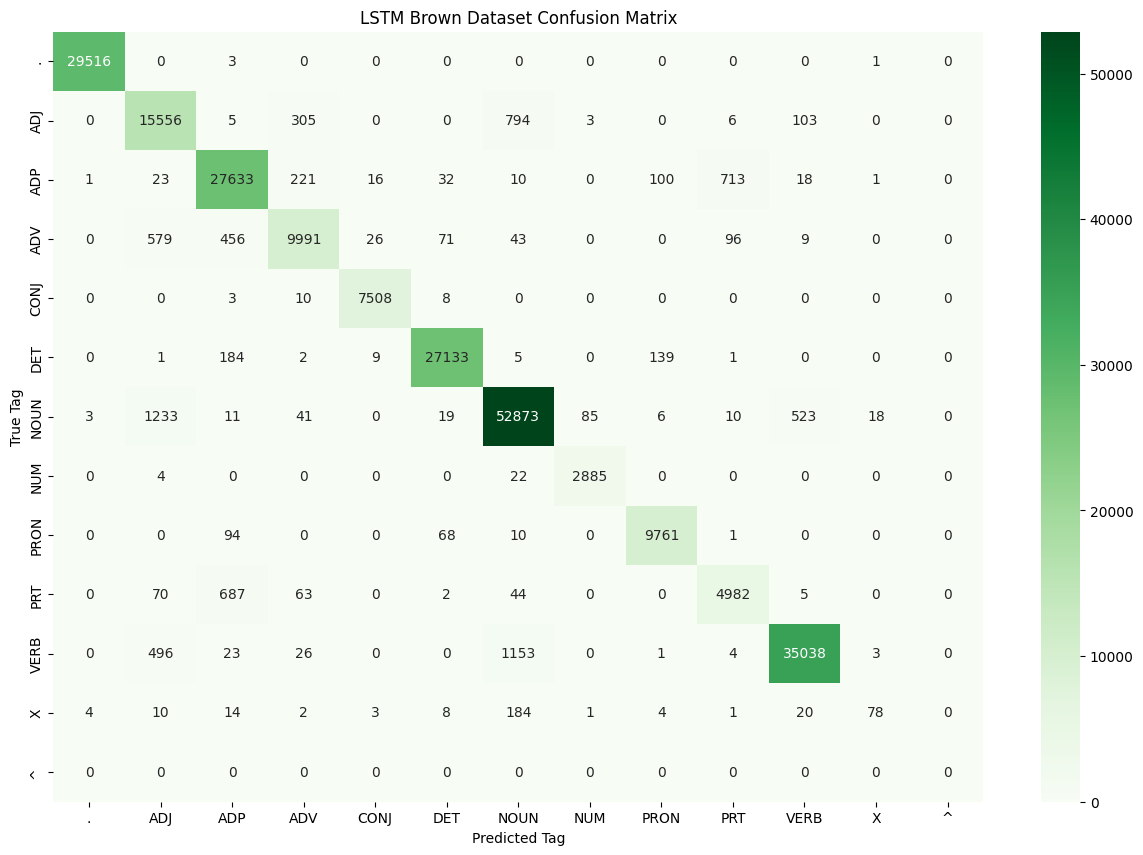

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Tag")
plt.ylabel("True Tag")
plt.title("LSTM Brown Dataset Confusion Matrix")
plt.show()